In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import torch
import torchvision.transforms.v2 as T

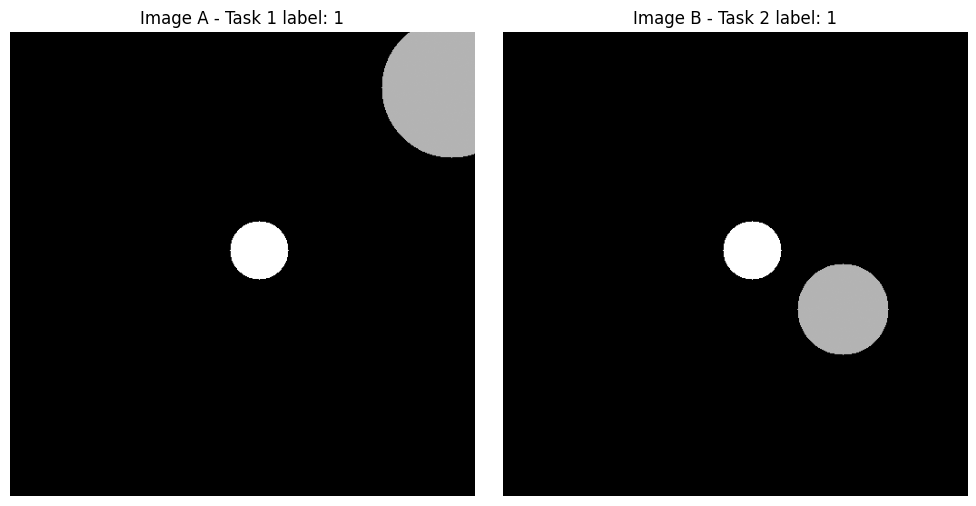

In [2]:


IMG_SIZE = 512
LATENT_DIM = 4

def draw_blob(image, center, radius, color=255):
    cv2.circle(image, center, radius, color, -1)

def latent_to_position(z, img_size):
    return tuple(((z[:2] + 1) / 2 * img_size).astype(int))  # map [-1, 1] -> [0, img_size]

def latent_to_radius(z, min_radius=20, max_radius=80):
    return int(((z[2] + 1) / 2) * (max_radius - min_radius) + min_radius)

def generate_sample():
    # Latents
    z_shared = np.random.uniform(-1, 1, LATENT_DIM)
    z_a = np.random.uniform(-1, 1, LATENT_DIM)
    z_b = np.random.uniform(-1, 1, LATENT_DIM)

    # Images
    img_a = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    img_b = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

    # Shared blob
    shared_center = latent_to_position(z_shared, IMG_SIZE)
    shared_radius = latent_to_radius(z_shared)
    draw_blob(img_a, shared_center, shared_radius)
    draw_blob(img_b, shared_center, shared_radius)

    # Private blobs
    private_a_center = latent_to_position(z_a, IMG_SIZE)
    private_a_radius = latent_to_radius(z_a)
    draw_blob(img_a, private_a_center, private_a_radius, color=180)

    private_b_center = latent_to_position(z_b, IMG_SIZE)
    private_b_radius = latent_to_radius(z_b)
    draw_blob(img_b, private_b_center, private_b_radius, color=180)

    # Labels (based on simple thresholds of latent sums)
    task1_label = np.digitize(np.sum(z_shared + z_a), [-1.5, 1.5])  # 0, 1, 2
    task2_label = np.digitize(np.sum(z_shared + z_b), [-1.5, 1.5])  # 0, 1, 2

    return img_a, img_b, task1_label, task2_label

# Visualize one pair
img_a, img_b, label1, label2 = generate_sample()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_a, cmap='gray')
axes[0].set_title(f'Image A - Task 1 label: {label1}')
axes[1].imshow(img_b, cmap='gray')
axes[1].set_title(f'Image B - Task 2 label: {label2}')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

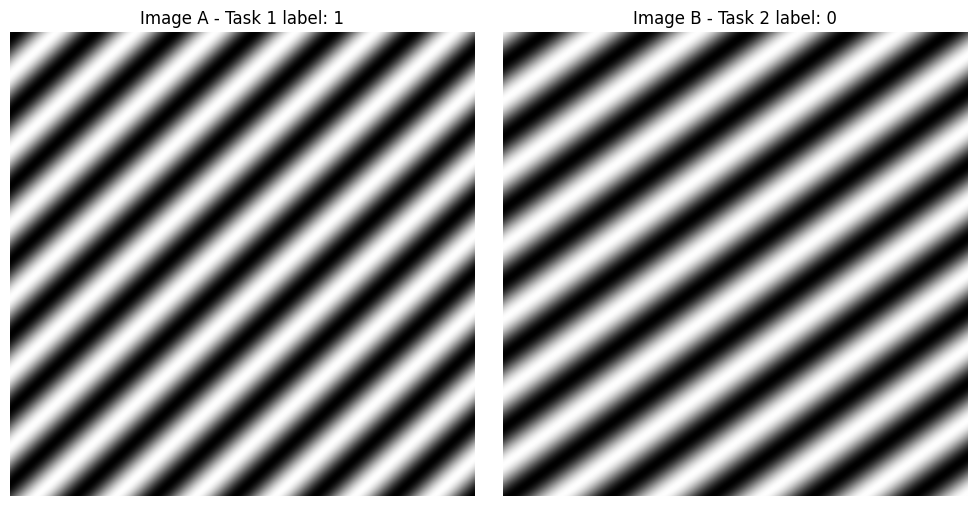

In [3]:
IMG_SIZE = 512
LATENT_DIM = 4

def generate_sinusoidal_pattern(z, img_size):
    A = (z[0] + 1) * 0.5  # amplitude in [0, 1]
    fx = (z[1] + 1) * 5   # frequency x in [0, 10]
    fy = (z[2] + 1) * 5   # frequency y
    phi = (z[3]) * np.pi # phase in [-π, π]

    x = np.linspace(0, 2 * np.pi, img_size)
    y = np.linspace(0, 2 * np.pi, img_size)
    X, Y = np.meshgrid(x, y)

    wave = A * np.sin(fx * X + fy * Y + phi)
    image = ((wave - wave.min()) / (wave.max() - wave.min()) * 255).astype(np.uint8)
    return image

def generate_sinusoidal_sample():
    z_shared = np.random.uniform(-1, 1, LATENT_DIM)
    z_a = np.random.uniform(-1, 1, LATENT_DIM)
    z_b = np.random.uniform(-1, 1, LATENT_DIM)

    img_a = generate_sinusoidal_pattern(z_shared + 0.5 * z_a, img_size = IMG_SIZE)
    img_b = generate_sinusoidal_pattern(z_shared + 0.5 * z_b, img_size = IMG_SIZE)

    task1_label = np.digitize(np.sum(z_shared + z_a), [-1.5, 1.5])
    task2_label = np.digitize(np.sum(z_shared + z_b), [-1.5, 1.5])

    return img_a, img_b, task1_label, task2_label

# Visualize
img_a, img_b, label1, label2 = generate_sinusoidal_sample()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_a, cmap='gray')
axes[0].set_title(f'Image A - Task 1 label: {label1}')
axes[1].imshow(img_b, cmap='gray')
axes[1].set_title(f'Image B - Task 2 label: {label2}')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

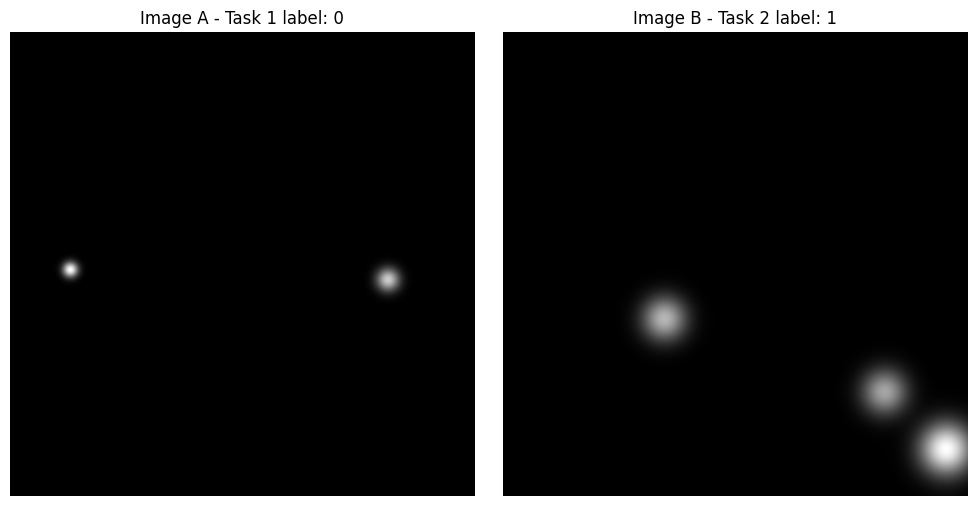

In [4]:


IMG_SIZE = 512
LATENT_DIM = 4
N_SPOTS = 3

def draw_gaussians(zs, img_size, n_spots=3):
    img = np.zeros((img_size, img_size), dtype=np.float32)
    x = np.linspace(0, 1, img_size)
    y = np.linspace(0, 1, img_size)
    X, Y = np.meshgrid(x, y)

    for i in range(n_spots):
        x0 = (zs[i*4+0] + 1) / 2  # [0, 1]
        y0 = (zs[i*4+1] + 1) / 2
        sigma = 0.02 + 0.08 * ((zs[i*4+2] + 1) / 2)  # spread
        amp = 0.5 + 0.5 * ((zs[i*4+3] + 1) / 2)      # amplitude

        gauss = amp * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))
        img += gauss

    img = np.clip(img / img.max(), 0, 1)
    return (img * 255).astype(np.uint8)

def generate_gaussian_sample():
    z_shared = np.random.uniform(-1, 1, LATENT_DIM * N_SPOTS)
    z_a = np.random.uniform(-1, 1, LATENT_DIM * N_SPOTS)
    z_b = np.random.uniform(-1, 1, LATENT_DIM * N_SPOTS)

    img_a = draw_gaussians(z_shared + 0.5 * z_a, IMG_SIZE, N_SPOTS)
    img_b = draw_gaussians(z_shared + 0.5 * z_b, IMG_SIZE, N_SPOTS)

    task1_label = np.digitize(np.sum(z_shared + z_a), [-2, 2])
    task2_label = np.digitize(np.sum(z_shared + z_b), [-2, 2])

    return img_a, img_b, task1_label, task2_label

# Visualize one sample
img_a, img_b, label1, label2 = generate_gaussian_sample()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_a, cmap='gray')
axes[0].set_title(f'Image A - Task 1 label: {label1}')
axes[1].imshow(img_b, cmap='gray')
axes[1].set_title(f'Image B - Task 2 label: {label2}')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [29]:
IMG_SIZE = 512
LATENT_DIM = 4

def generate_sinusoidal_pattern(z, img_size):
    fx = z[0]   # frequency x in [0, 10]
    fy = z[1]   # frequency y
    phi = (2*np.pi*z[2]) - np.pi  # phase in [-π, π]

    x = np.linspace(-np.pi, np.pi, img_size)
    y = np.linspace(-np.pi, np.pi, img_size)
    X, Y = np.meshgrid(x, y)

    wave = np.sin(fx * X + fy * Y + phi)

    # Apply exponential decay
    decay = np.exp(-((X)**2 + (Y)**2) / (2 * (np.pi / 2)**2))
    wave *= decay
    
    # flip the image vertically with 50% chance
    if np.random.rand() > 0.5:
        wave = np.flipud(wave)

    image = ((wave - wave.min()) / (wave.max() - wave.min()) * 255).astype(np.uint8)
    return image

def generate_sinc_pattern(z, img_size):
    a = z[0] # main axis in [0, 2]
    b = z[1] # minor axis in [0, 2]
    theta = np.pi*z[2]  # rotation angle in [0, π]

    x = np.linspace(-10, 10, img_size)
    y = np.linspace(-10, 10, img_size)
    X, Y = np.meshgrid(x, y)

    # Rotation transformation
    X_rot = X * np.cos(theta) - Y * np.sin(theta)
    Y_rot = X * np.sin(theta) + Y * np.cos(theta)

    sinc_wave = np.sinc((X_rot/a)**2 + (Y_rot/b)**2)

    image = ((sinc_wave - sinc_wave.min()) / (sinc_wave.max() - sinc_wave.min()) * 255).astype(np.uint8)
    return image
    

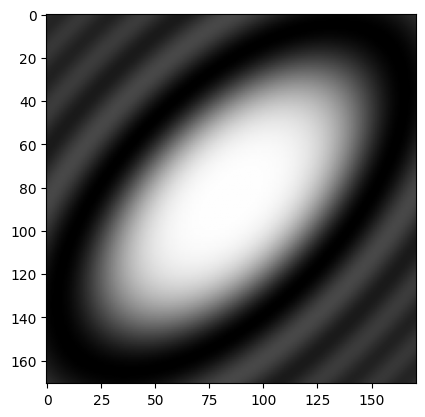

In [11]:
plt.imshow(generate_sinc_pattern(np.array([5, 10, 135/180]), img_size = int(np.ceil(IMG_SIZE / 3))), cmap='gray')

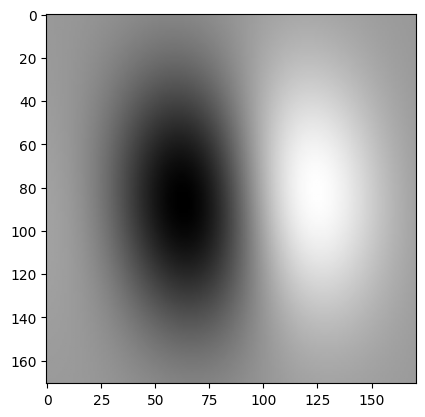

In [10]:
plt.imshow(generate_sinusoidal_pattern(np.array([np.random.rand()/10+0.9, np.random.rand()/5, np.random.rand()]), img_size = int(np.ceil(IMG_SIZE / 3))), cmap='gray')

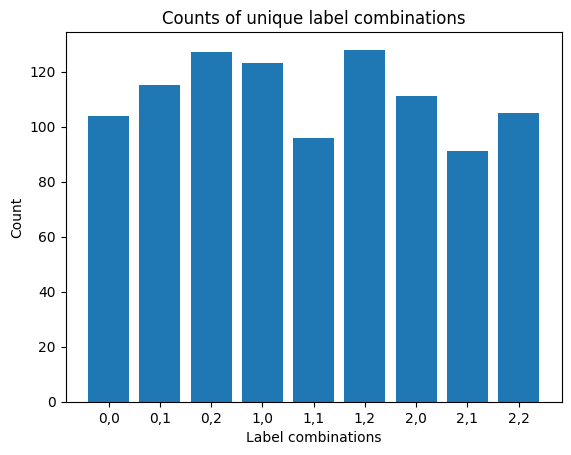

In [26]:
labels = np.random.randint(0, 3, size=(1000, 2))

unique, counts = np.unique(labels, axis=0, return_counts=True)
plt.bar([f"{a},{b}" for a, b in unique], counts)
plt.xlabel("Label combinations")
plt.ylabel("Count")
plt.title("Counts of unique label combinations")
plt.show()

In [7]:
img_size = 512
def generate_sinusoidal_pattern(z, img_size):
    fx = z[0]  # frequency x in [0, 10]
    fy = z[1]  # frequency y
    phi = (2 * np.pi * z[2]) - np.pi  # phase in [-π, π]

    x = np.linspace(-np.pi, np.pi, img_size)
    y = np.linspace(-np.pi, np.pi, img_size)
    X, Y = np.meshgrid(x, y)

    wave = np.sin(fx * X + fy * Y + phi)

    # Apply exponential decay
    decay = np.exp(-((X) ** 2 + (Y) ** 2) / (2 * (np.pi / 2) ** 2))
    wave *= decay

    # flip the image vertically with 50% chance
    if np.random.rand() > 0.5:
        wave = np.flipud(wave)

    image = ((wave - wave.min()) / (wave.max() - wave.min()) * 255).astype(np.uint8)
    return image

def generate_sinc_pattern(z, img_size):
    a = z[0]  # main axis in [0, 2]
    b = z[1]  # minor axis in [0, 2]
    theta = np.pi * z[2]  # rotation angle in [0, π]

    x = np.linspace(-10, 10, img_size)
    y = np.linspace(-10, 10, img_size)
    X, Y = np.meshgrid(x, y)

    # Rotation transformation
    X_rot = X * np.cos(theta) - Y * np.sin(theta)
    Y_rot = X * np.sin(theta) + Y * np.cos(theta)

    sinc_wave = np.sinc((X_rot / a) ** 2 + (Y_rot / b) ** 2)

    image = (
        (sinc_wave - sinc_wave.min()) / (sinc_wave.max() - sinc_wave.min()) * 255
    ).astype(np.uint8)
    return image

def generate_random_parameters(task1, task2):
    """
    match task1:
        case 0:
            task1_indiv1 = [[0, 2], [7, 8]]
            task1_indiv2 = [[11, 12], [0, 2]]
            task1_shared = [[1, 3], [1, 3]]
        case 1:
            task1_indiv1 = [[0, 2], [9, 10]]
            task1_indiv2 = [[9, 10], [0, 2]]
            task1_shared = [[4, 6], [4, 6]]
        case 2:
            task1_indiv1 = [[0, 2], [11, 12]]
            task1_indiv2 = [[7, 8], [0, 2]]
            task1_shared = [[7, 9], [7, 9]]
        case _:
            print("Wrong class label")
    """
    
    match task1:
        case 0:
            task1_indiv1 = [1, 7.5]
            task1_indiv2 = [11.5, 1]
            task1_shared = [2, 2]
        case 1:
            task1_indiv1 = [1, 9.5]
            task1_indiv2 = [9.5, 1]
            task1_shared = [5, 5]
        case 2:
            task1_indiv1 = [1, 11.5]
            task1_indiv2 = [7.5, 1]
            task1_shared = [8, 8]
        case _:
            print("Wrong class label")
    
    
 
    match task2:
        case 0:
            task2_indiv1 = [[1, 2.5], 2, [30 / 180, 60 / 180]]
            task2_indiv2 = [[3.5, 5], 4, [120 / 180, 150 / 180]]
            task2_shared = [[1, 5], 2, [-15 / 180, 15 / 180]]
        case 1:
            task2_indiv1 = [[1, 2.5], 2.5, [30 / 180, 60 / 180]]
            task2_indiv2 = [[3.5, 5], 3, [120 / 180, 150 / 180]]
            task2_shared = [[1, 5], 2.5, [-15 / 180, 15 / 180]]
        case 2:
            task2_indiv1 = [[1, 2.5], 3, [30 / 180, 60 / 180]]
            task2_indiv2 = [[3.5, 5], 2, [120 / 180, 150 / 180]]
            task2_shared = [[1, 5], 3, [-15 / 180, 15 / 180]]
        case _:
            print("Wrong class label")
  
            
    sigma = 0.5
    task1_indiv1 = [
        np.random.normal(loc=task1_indiv1[0], scale=sigma),
        np.random.normal(loc=task1_indiv1[1], scale=sigma),
        np.random.uniform(0, 1),
    ]
    task1_indiv2 = [
        np.random.normal(loc=task1_indiv2[0], scale=sigma),
        np.random.normal(loc=task1_indiv2[1], scale=sigma),
        np.random.uniform(0, 1),
    ]
    task1_shared = [
        np.random.normal(loc=task1_shared[0], scale=1.5*sigma),
        np.random.normal(loc=task1_shared[1], scale=1.5*sigma),
        np.random.uniform(0, 1),
    ]
    
    
    
    '''
    task1_indiv1 = [
        random.uniform(task1_indiv1[0][0], task1_indiv1[0][1]),
        random.uniform(task1_indiv1[1][0], task1_indiv1[1][1]),
        random.random(),
    ]
    task1_indiv2 = [
        random.uniform(task1_indiv2[0][0], task1_indiv2[0][1]),
        random.uniform(task1_indiv2[1][0], task1_indiv2[1][1]),
        random.random(),
    ]
    task1_shared = [
        random.uniform(task1_shared[0][0], task1_shared[0][1]),
        random.uniform(task1_shared[1][0], task1_shared[1][1]),
        random.random(),
    ]'''
    sigma = 0.15
    task2_indiv1 = random.uniform(
        task2_indiv1[0][0], task2_indiv1[0][1]
    ) * np.array([1, np.random.normal(loc=task2_indiv1[1], scale=sigma), 0]) + np.array(
        [0, 0, random.uniform(task2_indiv1[2][0], task2_indiv1[2][1])]
    )
    task2_indiv2 = random.uniform(
        task2_indiv2[0][0], task2_indiv2[0][1]
    ) * np.array([1, np.random.normal(loc=task2_indiv2[1], scale=2*sigma), 0]) + np.array(
        [0, 0, random.uniform(task2_indiv2[2][0], task2_indiv2[2][1])]
    )
    task2_shared = random.uniform(
        task2_shared[0][0], task2_shared[0][1]
    ) * np.array([1, np.random.normal(loc=task2_shared[1], scale=sigma), 0]) + np.array(
        [0, 0, random.uniform(task2_shared[2][0], task2_shared[2][1])]
    )
    
    '''
    task2_indiv1 = random.uniform(
        task2_indiv1[0][0], task2_indiv1[0][1]
    ) * np.array([1, task2_indiv1[1], 0]) + np.array(
        [0, 0, random.uniform(task2_indiv1[2][0], task2_indiv1[2][1])]
    )
    task2_indiv2 = random.uniform(
        task2_indiv2[0][0], task2_indiv2[0][1]
    ) * np.array([1, task2_indiv2[1], 0]) + np.array(
        [0, 0, random.uniform(task2_indiv2[2][0], task2_indiv2[2][1])]
    )
    task2_shared = random.uniform(
        task2_shared[0][0], task2_shared[0][1]
    ) * np.array([1, task2_shared[1], 0]) + np.array(
        [0, 0, random.uniform(task2_shared[2][0], task2_shared[2][1])]
    )
    '''
    match task1:
        case 0:
            match task2:
                case 0:
                    task_shared = [0.5, 0.5]
                case 1:
                    task_shared = [2, 2]
                case 2:
                    task_shared = [3.5, 3.5]
                case _:
                    print("Wrong class label")
        case 1:
            match task2:
                case 0:
                    task_shared = [5, 5]
                case 1:
                    task_shared = [6.5, 6.5]
                case 2:
                    task_shared = [8, 8]
                case _:
                    print("Wrong class label")
        case 2:
            match task2:
                case 0:
                    task_shared = [9.5, 9.5]
                case 1:
                    task_shared = [11, 11]
                case 2:
                    task_shared = [12.5, 12.5]
                case _:
                    print("Wrong class label")
        case _:
            print("Wrong class label")

    sigma = 1.5
    task_shared = [
        np.random.normal(loc=task_shared[0], scale=sigma),
        np.random.normal(loc=task_shared[1], scale=sigma),
        np.random.uniform(0, 1),
    ]
            
    return [
        task1_indiv1,
        task1_indiv2,
        task1_shared,
        task2_indiv1,
        task2_indiv2,
        task2_shared,
        task_shared
    ]

def generate_image(index, parameters):
    sub_img_size = img_size // 3 + 1

    (
        task1_indiv1,
        task1_indiv2,
        task1_shared,
        task2_indiv1,
        task2_indiv2,
        task2_shared,
        task_shared
        
    ) = parameters[index]

    task1_indiv1 = generate_sinusoidal_pattern(
        task1_indiv1, img_size=sub_img_size
    )
    task1_indiv2 = generate_sinusoidal_pattern(
        task1_indiv2, img_size=sub_img_size
    )
    task1_shared = generate_sinusoidal_pattern(
        task1_shared, img_size=sub_img_size
    )

    task2_indiv1 = generate_sinc_pattern(task2_indiv1, img_size=sub_img_size)
    task2_indiv2 = generate_sinc_pattern(task2_indiv2, img_size=sub_img_size)
    task2_shared = generate_sinc_pattern(task2_shared, img_size=sub_img_size)

    task_shared = generate_sinusoidal_pattern(task_shared, img_size=sub_img_size)

    fill = np.zeros((sub_img_size, sub_img_size), dtype=np.uint8)

    view1 = np.block(
        [
            [task1_shared, task1_indiv1, fill],
            [task1_indiv1, task_shared, task2_indiv1],
            [fill, task2_indiv1, task2_shared],
        ]
    )

    view2 = np.block(
        [
            [task1_indiv2, task1_shared, task1_indiv2],
            [fill, task_shared, fill],
            [task2_indiv2, task2_shared, task2_indiv2],
        ]
    )

    # Convert views to float32 and stack
    images = [view1.astype(np.float32), view2.astype(np.float32)]

    # Convert to torch tensor and add channel dimension if needed
    tensor_images = [
        torch.from_numpy(image).unsqueeze(0) for image in images
    ]  # shape: (1, H, W)

    # Concatenate local transform with self.transform if provided
    # Resize using torchvision transforms
    transform = T.Compose(
        [
            T.Resize((img_size, img_size)),  # expects (C, H, W)
            T.Normalize(mean=[0], std=[255.0]),  # Normalize to [0, 1]
        ]
    )

    # Apply transform to each view
    tensor_images = [
        transform(img) for img in tensor_images
    ]  # shape: (1, img_size, img_size)

    return tensor_images

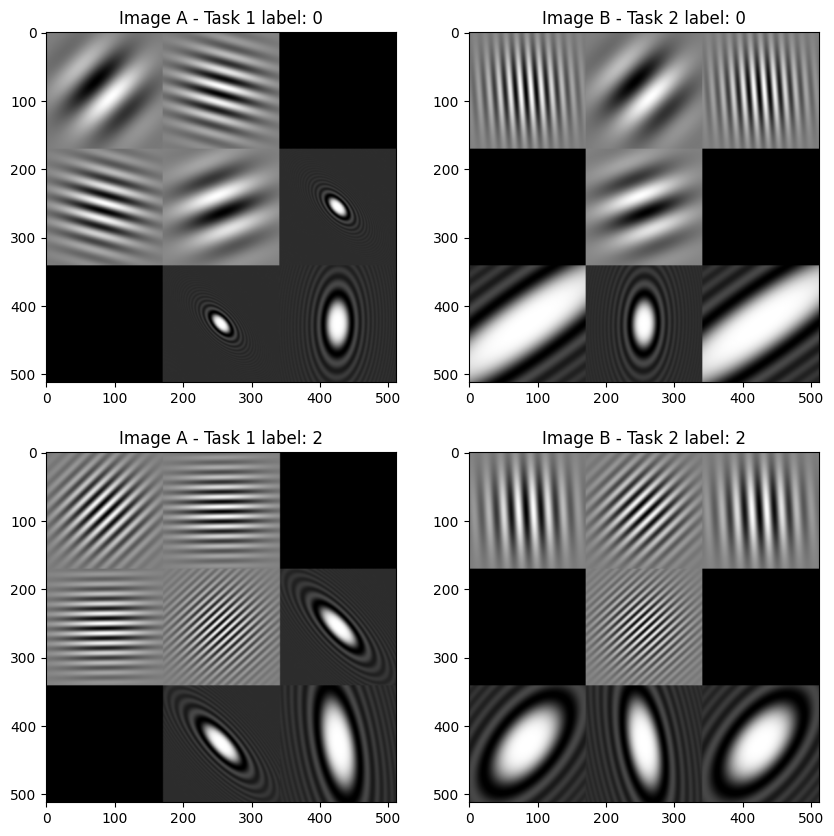

In [8]:
labels = np.random.randint(0, 3, size=(10, 2))
labels = ((0,0),(2,2))
params = [generate_random_parameters(l[0], l[1]) for l in labels]
imgs = [generate_image(i, params) for i in range(len(params))]
# Visualize the generated images
fig, axes = plt.subplots(len(imgs), 2, figsize=(10, 5 * len(imgs)))
for idx, (ax, img) in enumerate(zip(axes, imgs)):
    ax[0].imshow(img[0].squeeze().cpu().numpy(), cmap='gray')
    ax[1].imshow(img[1].squeeze().cpu().numpy(), cmap='gray')
    ax[0].set_title(f'Image A - Task 1 label: {labels[idx][0]}')
    ax[1].set_title(f'Image B - Task 2 label: {labels[idx][1]}')


<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/var/folders/cn/n79zw47n1sx9pr64jl2gkz9c0000gp/T/ipykernel_37274/1790420621.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, y, label=f'$\mu$={mu}, $\sigma$={sigma}')
/var/folders/cn/n79zw47n1sx9pr64jl2gkz9c0000gp/T/ipykernel_37274/1790420621.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, y, label=f'$\mu$={mu}, $\sigma$={sigma}')


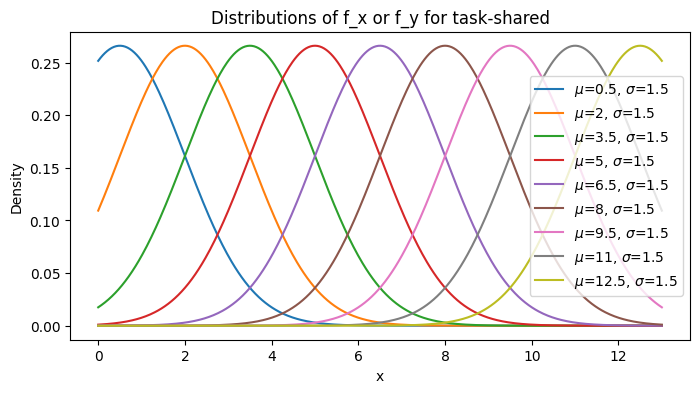

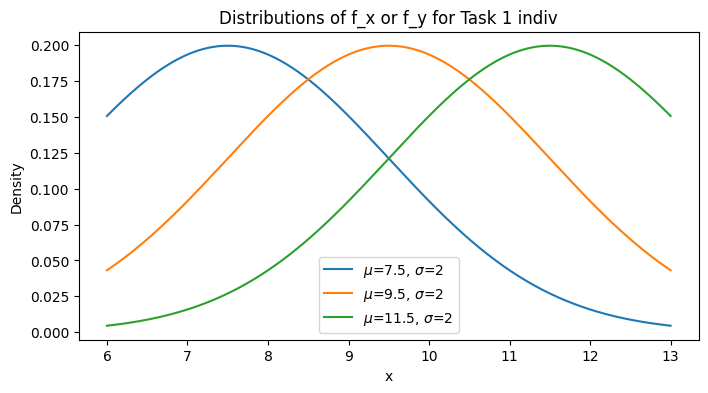

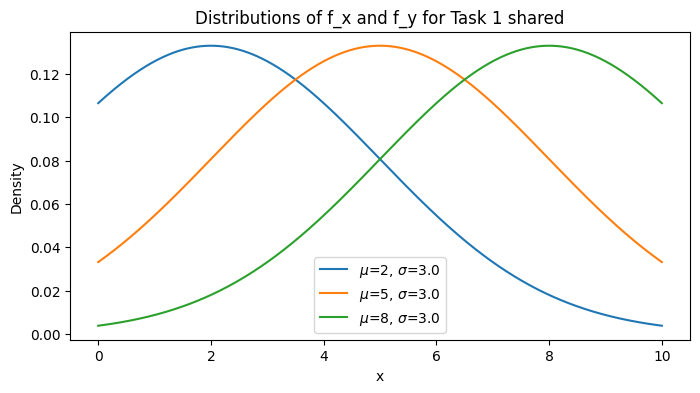

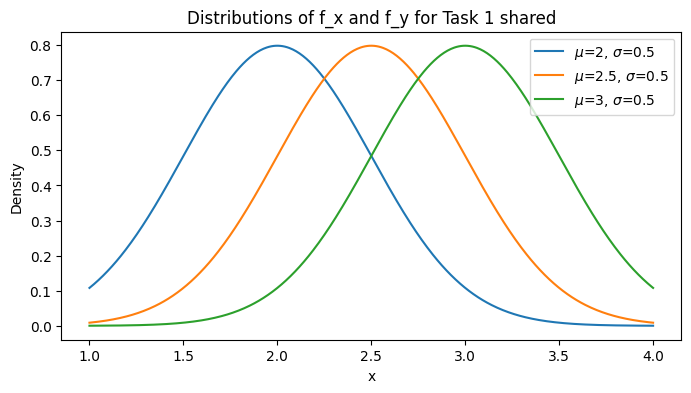

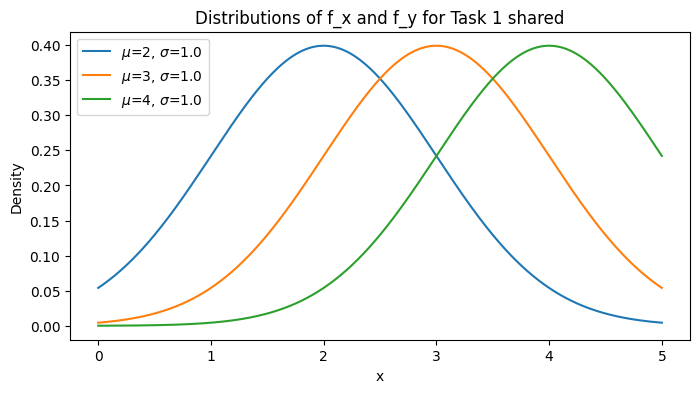

In [6]:
def plot_1d_gaussians(params_list, x_range=(-5, 5), num_points=500, title="1D Gaussian Densities"):
    """
    Plots 1D Gaussian densities for a list of (mean, std) parameter tuples.
    """
    x = np.linspace(x_range[0], x_range[1], num_points)
    plt.figure(figsize=(8, 4))
    for i, (mu, sigma) in enumerate(params_list):
        y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu)/sigma)**2)
        plt.plot(x, y, label=f'$\mu$={mu}, $\sigma$={sigma}')
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Example usage:
sigma = 1.5
params_list = [(0.5, sigma), (2, sigma), (3.5, sigma), (5, sigma), (6.5, sigma), (8, sigma), (9.5, sigma), (11, sigma), (12.5, sigma)]
plot_1d_gaussians(params_list, x_range=(0, 13), title="Distributions of f_x or f_y for task-shared")

sigma = 2
params_list = [(7.5, sigma), (9.5, sigma), (11.5, sigma)]
plot_1d_gaussians(params_list, x_range=(6,13), title="Distributions of f_x or f_y for Task 1 indiv")
sigma *= 1.5
params_list = [(2, sigma), (5, sigma), (8, sigma)]
plot_1d_gaussians(params_list, x_range=(0,10), title="Distributions of f_x and f_y for Task 1 shared")


sigma = 0.5
params_list = [(2, sigma), (2.5, sigma), (3, sigma)]
plot_1d_gaussians(params_list, x_range=(1,4), title="Distributions of f_x and f_y for Task 1 shared")

sigma *= 2
params_list = [(2, sigma), (3, sigma), (4, sigma)]
plot_1d_gaussians(params_list, x_range=(0,5), title="Distributions of f_x and f_y for Task 1 shared")



In [1]:
from src import Synthetic_2v_Dataloader
import torchvision.transforms.v2 as T
transform = T.Compose([
            T.RandomHorizontalFlip(0.5),
            T.RandomVerticalFlip(0.5),
            T.GaussianNoise(0.1, 0.1),
        ])
loader = Synthetic_2v_Dataloader(transform=transform, n_samples=[100, 50, 50])



Generating synthetic images: 100%|██████████| 50/50 [00:01<00:00, 25.68it/s]


In [3]:
next(iter(loader.train_dataloader()))  # Get the first batch

[[tensor([[[[0.1032, 0.0009, 0.1247,  ..., 0.6497, 0.4718, 0.6250],
            [0.1329, 0.0000, 0.1130,  ..., 0.4638, 0.5380, 0.6948],
            [0.1355, 0.0857, 0.0000,  ..., 0.5838, 0.6573, 0.5158],
            ...,
            [0.2839, 0.3197, 0.3011,  ..., 0.0554, 0.1163, 0.0471],
            [0.3388, 0.2738, 0.3389,  ..., 0.0000, 0.1456, 0.2621],
            [0.2166, 0.1289, 0.4165,  ..., 0.2204, 0.0000, 0.3189]]],
  
  
          [[[0.5863, 0.5554, 0.7038,  ..., 0.0000, 0.0981, 0.3008],
            [0.9008, 0.4175, 0.6433,  ..., 0.1149, 0.0000, 0.0595],
            [0.6282, 0.5834, 0.5873,  ..., 0.1949, 0.0732, 0.0593],
            ...,
            [0.0000, 0.0051, 0.1667,  ..., 0.2367, 0.2748, 0.1645],
            [0.2103, 0.2005, 0.1827,  ..., 0.1859, 0.1292, 0.2386],
            [0.0567, 0.0145, 0.0668,  ..., 0.4346, 0.3012, 0.1515]]],
  
  
          [[[0.0000, 0.1873, 0.1108,  ..., 0.5742, 0.6609, 0.4665],
            [0.2191, 0.0191, 0.0000,  ..., 0.6544, 0.6948, 0.5558]

In [15]:
from torchsummary import summary

summary(net, input_size=(2, 1, 512, 512))

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [2, 2, 1, 512, 512]

In [7]:
print(net)

TwoViewCNN(
  (loss): CrossEntropyLoss()
  (confusion_matrix): ModuleList(
    (0): MulticlassConfusionMatrix()
  )
  (resnexts): ModuleList(
    (0-1): 2 x ResNeXt(
      (conv_1_3x3): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn_1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (stage_1): Sequential(
        (stage_1_bottleneck_0): ResNeXtBottleneck(
          (conv_reduce): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn_reduce): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
          (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv_expand): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn_expand): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running